<style>
figcaption {
  margin: auto;
  text-align: center;
</style>

<div style="text-align: right;">
  <a href="https://colab.research.google.com/github/drscotthawley/blog/blob/main/extra/FlowModels_colab.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </a>
</div>

### Abstract {.unnumbered}

In this tutorial post, we provide an accessible introduction to flow-matching and rectified flow models, which are increasingly on the forefront of generative AI applications. Typical descriptions of them are usually laden with extensive probability-math equations, which can form barriers to the dissemination and understanding of these models. Fortunately, before they were couched in probabilities, the mechanisms underlying these models were grounded in basic physics, which provides an alternative and highly-accessible (yet isomorphic) representation of the processes involved. Let's flow. 

# Introduction



Flow-based generative AI models have been gaining significant traction as alternatives or improvements to traditional diffusion approaches in image and audio synthesis. These models excel at learning optimal trajectories for transforming probability distributions, offering a mathematically elegant framework for data generation. The approach has seen renewed momentum following Black Forest Labs' success with their FLUX models [@flux_paper], spurring fresh interest in the theoretical foundations laid by earlier work on Rectified Flows [@rectified_flow] in ICLR 2023. Improvements such as [@improving_rf] have even reached the level of state-of-the-art generative models for one or two-step generation.

Intuitively, these models operate akin to the fluid processes that transform the shapes of clouds in the sky. While recent expositions [@jia_bin] have attempted to make these concepts more accessible through probability theory, the underlying physical principles offer a more direct path to understanding.   By returning to the basic physical picture of flows that inspired these generative models, we can build both intuition and deep understanding - insights that may even guide the development of new approaches.

![Source: Face-morphing example from Michael Jackson's  "Black Or White" (1991). <br>Technically not a flow-based generative model[@mj_siggraph] but similar enough to use for an intro image. ;-) ](images/mj-bw.gif){height=300 fig-align="center"} 

## What's a Flow? 
In the real world, things typically follow curved paths - like water flowing in a river, or crowds of people navigating around obstacles.  Here's map of wind provided from the WW2010 atmospheric science project at UIUC: at every point in space, the wind has a velocity vector, and the air moves along "streamlines" or "trajectories" parallel to the velocity vectors...

![Wind flow map image from the [University of Illinois WW2010 Project](http://ww2010.atmos.uiuc.edu/(Gh)/guides/maps/upa/wndvct.rxml)](images/3wndhght.gif){fig-align="center"}

Notice that the streamlines never cross.  If the streams were to cross... "it would be bad." That would imply that the velocity at some point is undefined.

![](images/gb-dont-cross-streams.gif){width=80% fig-align="center"}

::: {.callout-tip title="Non-Crossing == Invertible"}

This non-crossing property is what allows these flows to be invertible (i.e., reversable), a property you sometimes hear in isolation when reading more formal descriptions of flow models.
:::


So, at every point in space there's a velocity vector telling the little bits of fluid where to go. And just like water or wind flows may depend not only on spatial position but also time, so too can our velocity vector field depend on position and time. 

Flow matching learns these natural paths by focusing on the *velocity* at each point - essentially asking "which way should each point be moving at this moment?"

::: {.callout-note title="Terminology: \"FM/RF\""}

It may seem confusing to sometimes see "flow matching" and "rectified flows" being used interchangeably, but this is because they are *the same* [@tanishq_same]. In this blog we'll use the collective term "FM/RF" models.  
Also note that there is no explicit "rectification" mechanism in rectified flows; rather any "rectification" is a description of the effect of flow-matching, i.e. transformingn crossing trajectories to non-crossing ones. The addition of "Reflow" to the rectified flow paper [@rectified_flow] is a powerful extension we will cover further below.
:::

# How Do FM/RF Models Work?

To gain a deep understanding of how models work, having an executable toy model is often a key instructional tool.  This tutorial is written as a [executable Jupyter notebook](https://colab.research.google.com/github/drscotthawley/blog/blob/main/extra/FlowModels_colab.ipynb), though you can make sense of it without the code, so we will typically collapse or hide the code. But if you want to see it, you can expand the drop-down arrows.  

For instance, the code starts with importing packages...

In [ ]:
#| code-fold: true
#| code-summary: "Installs & imports"

# Uncomment to install any missing packages:
#%pip install torch numpy matplotlib tqdm 
    
import torch
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from tqdm.notebook import tqdm

**Choose Your Own Data Shapes**

The [executable verison of this lesson](https://colab.research.google.com/github/drscotthawley/blog/blob/main/extra/FlowModels_colab.ipynb) lets you choose various shapes to "morph" between. For this reading, we'll go from a Gaussian to a Spiral: 

In [ ]:
# Options are: 'Gaussian', 'Square', 'Heart', 'Spiral','Two Gaussians', 'Smiley'
source_data_choice = 'Gaussian'
target_data_choice = 'Spiral'       

With the imports in place and the choice of starting and ending distributions chosen, we're ready to define some of utilities to generate and visualize our data. Let's take a look:

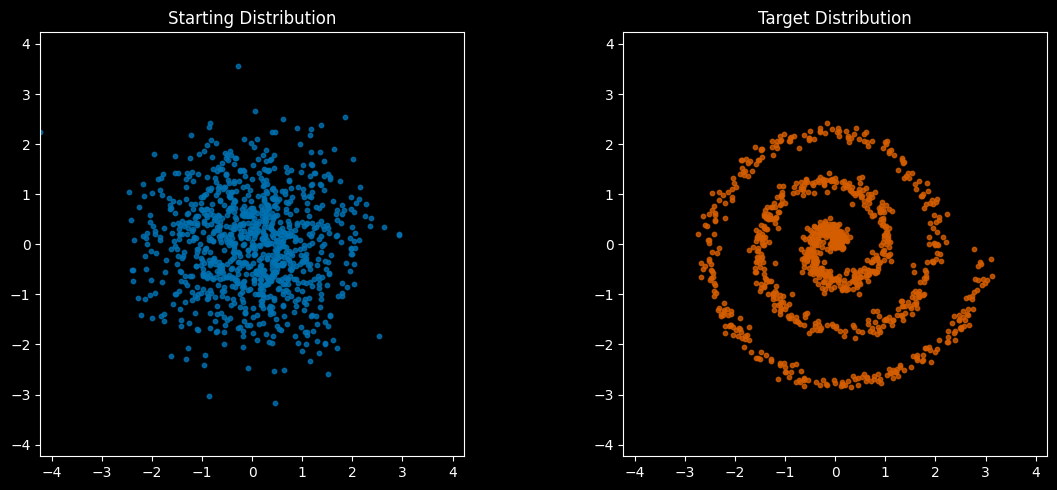

In [ ]:
#| code-fold: true
#| code-summary: "Utility code: styles, functions, generators, visualization"

# for accessibility: Wong's color pallette: cf. https://davidmathlogic.com/colorblind
#wong_black = [0/255, 0/255, 0/255]          # #000000
wong_amber = [230/255, 159/255, 0/255]      # #E69F00
wong_cyan = [86/255, 180/255, 233/255]      # #56B4E9
wong_green = [0/255, 158/255, 115/255]      # #009E73
wong_yellow = [240/255, 228/255, 66/255]    # #F0E442
wong_navy = [0/255, 114/255, 178/255]       # #0072B2
wong_red = [213/255, 94/255, 0/255]         # #D55E00
wong_pink = [204/255, 121/255, 167/255]     # #CC79A7
wong_cmap = [wong_amber, wong_cyan, wong_green, wong_yellow, wong_navy, wong_red, wong_pink]

source_color = wong_navy
target_color = wong_red
pred_color = wong_green
line_color = wong_yellow
bg_theme = 'dark' #  'black', 'white', 'dark', 'light'
if bg_theme in ['black','dark']:
    plt.style.use('dark_background')
else:
    plt.rcdefaults()
    

# A few different data distributions
def create_gaussian_data(n_points=1000, scale=1.0):
    """Create a 2D Gaussian distribution"""
    return torch.randn(n_points, 2) * scale

def create_square_data(n_points=1000, scale=3.0):  # 3 is set by the spread of the gaussian and spiral 
    """Create points uniformly distributed in a square"""
    # Generate uniform points in a square
    points = (torch.rand(n_points, 2) * 2 - 1) * scale
    return points
 
def create_spiral_data(n_points=1000, scale=1):
    """Create a spiral distribution. i like this one more"""
    noise = 0.1*scale 
    #theta = torch.linspace(0, 6*np.pi, n_points) # preferred order? no way
    theta = 6*np.pi* torch.rand(n_points)
    r = theta / (2*np.pi) * scale
    x = r * torch.cos(theta) + noise * torch.randn(n_points)
    y = r * torch.sin(theta) + noise * torch.randn(n_points)
    return torch.stack([x, y], dim=1)

def create_heart_data(n_points=1000, scale=3.0):
    """Create a heart-shaped distribution of points"""
    square_points = create_square_data(n_points, scale=1.0)
    
    # Calculate the heart-shaped condition for each point
    x, y = square_points[:, 0], square_points[:, 1]
    heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
    
    # Filter out points that don't satisfy the heart-shaped condition
    heart_points = square_points[heart_condition]
    
    # If we don't have enough points, generate more
    while len(heart_points) < n_points:
        new_points = create_square_data(n_points - len(heart_points), scale=1)
        x, y = new_points[:, 0], new_points[:, 1]
        new_heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
        new_heart_points = new_points[new_heart_condition]
        heart_points = torch.cat([heart_points, new_heart_points], dim=0)

    heart_points *= scale 
    return heart_points[:n_points]

def create_two_gaussians_data(n_points=1000, scale=1.0, shift=2.5):
    """Create a 2D Gaussian distribution"""
    g  = torch.randn(n_points, 2) * scale
    g[:n_points//2,0] -= shift
    g[n_points//2:,0] += shift
    indices = torch.randperm(n_points)
    return g[indices]


def create_smiley_data(n_points=1000, scale=2.5):
    "make a smiley face"
    points = []
    # Face circle
    #angles = 2 * np.pi * torch.rand(n_points//2+20)
    #r = scale + (scale/10)*torch.sqrt(torch.rand(n_points//2+20)) 
    #points.append(torch.stack([r * torch.cos(angles), r * torch.sin(angles)], dim=1))
    
    # Eyes (small circles at fixed positions)
    for eye_pos in [[-1, 0.9], [1, 0.9]]:
        eye = torch.randn(n_points//3+20, 2) * 0.2 + torch.tensor(eye_pos) * scale * 0.4
        points.append(eye)
        
    # Smile (arc in polar coordinates)
    theta = -np.pi/6 - 2*np.pi/3*torch.rand(n_points//3+20) 
    r_smile = scale * 0.6 + (scale/4)* torch.rand_like(theta)
    points.append(torch.stack([r_smile * torch.cos(theta), r_smile * torch.sin(theta)], dim=1))
    
    points = torch.cat(points, dim=0)  # concatenate first
    points = points[torch.randperm(points.shape[0])]  # then shuffle
    return points[:n_points,:]
    

# Initialize generator functions
source_gen_fn = None
target_gen_fn = None

# Assign generator functions based on user choices
for gen_choice, gen_fn_name in zip([source_data_choice, target_data_choice], ['source_gen_fn', 'target_gen_fn']):
    gen_choice = gen_choice.lower()
    if 'two gaussians' in gen_choice:
        gen_fn = create_two_gaussians_data
    elif 'heart' in gen_choice:
        gen_fn = create_heart_data
    elif 'spiral' in gen_choice:
        gen_fn = create_spiral_data
    elif 'square' in gen_choice:
        gen_fn = create_square_data
    elif 'smiley' in gen_choice:
        gen_fn = create_smiley_data
    else:
        gen_fn = create_gaussian_data
    
    if gen_fn_name == 'source_gen_fn':
        source_gen_fn = gen_fn
    else:
        target_gen_fn = gen_fn
        
# A couple aliases so we can easily switch distributions without affecting later code 
def create_source_data(n_points=1000, hshift=0):  # hshift can make it a bit easier to see trajectories later
    g = source_gen_fn(n_points=n_points)
    if hshift != 0: g[:,0] += hshift
    return g
    
def create_target_data(n_points=1000, hshift=0):
    g = target_gen_fn(n_points=n_points)
    if hshift != 0: g[:,0] += hshift
    return g

def plot_distributions(dist1, dist2, title1="Distribution 1", title2="Distribution 2", alpha=0.8):
    """Plot two distributions side by side"""
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(dist1[:, 0], dist1[:, 1], alpha=alpha, s=10, color=source_color)
    ax2.scatter(dist2[:, 0], dist2[:, 1], alpha=alpha, s=10, color=target_color)
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    
    # Set same scale for both plots
    max_range = max(
        abs(dist1).max().item(),
        abs(dist2).max().item()
    )
    for ax in [ax1, ax2]:
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()  # Explicitly show the plot
    plt.close()



def interpolate_color(t, start='blue', end='red'):
    """Interpolate from matplotlib's default green (t=0) to red (t=1)"""
    start_color = plt.cm.colors.to_rgb(start)
    end_color = plt.cm.colors.to_rgb(end)
    return (1-t) * np.array(start_color) + t * np.array(end_color)


def show_flow_sequence(start_dist, end_dist, n_steps=5, c_start=source_color, c_end=target_color):
    """Show the flow as a sequence of static plots"""
    fig, axes = plt.subplots(1, n_steps, figsize=(4*n_steps, 4))
    
    max_range = max(
        abs(start_dist).max().item(),
        abs(end_dist).max().item()
    )
    
    for i, ax in enumerate(axes):
        t = i / (n_steps - 1)
        current = start_dist * (1-t) + end_dist * t
        
        color = interpolate_color(t, start=c_start, end=c_end)
        ax.scatter(current[:, 0], current[:, 1], 
                  alpha=0.8, s=10, 
                  c=[color])
        
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        ax.set_title(f't = {t:.2f}')
    
    plt.tight_layout()
    plt.show()
    plt.close()



# Create our distributions and look at them
n_points = 1000
source, target = create_source_data(n_points), create_target_data(n_points)

plot_distributions(source, target, "Starting Distribution", "Target Distribution")

The process of transition from the starting "source" to the final "target" might include snapshots like these:

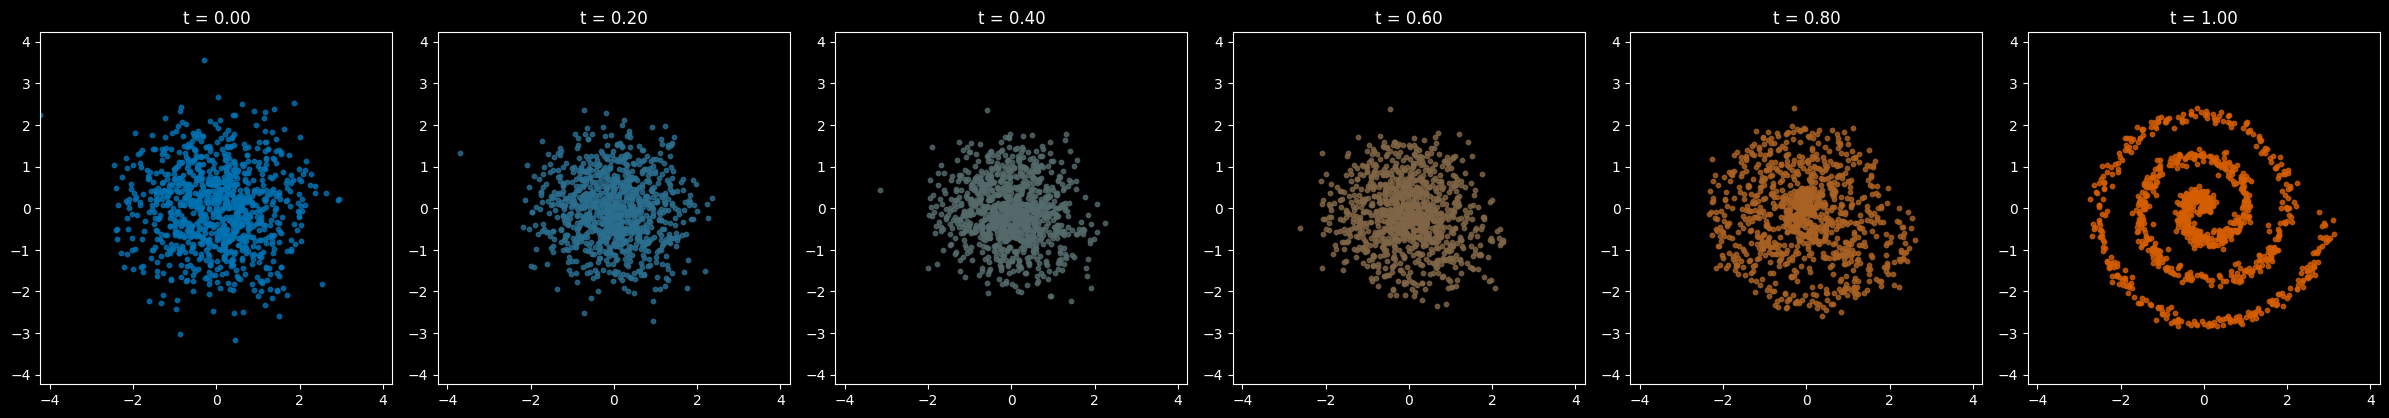

In [ ]:
#| echo: false
show_flow_sequence(source, target, n_steps=6)

(Note the colors aren't meaningful, they're just added to make it easier to distinguish what we're looking at. Our data are just points in 2-D space.)

<!---Here's an animation with no colors, showing the points moving. ... --->

So, how do we get the points from the source distribution to fit with the target distribution? The simplest way (though not the only way) is to assume points move in straight lines from source to target. Even though our network might learn more complex paths later, this gives us a starting point for training.

## The Starting Setup

The training setup for flow matching models is as follows:

1. We start by *randomly pairing* points from the source & the target -- yes, really. 🤣
2. We move the points along straight trajectories, and the speed of each point is constant.


In [ ]:
#| code-fold: true
#| code-summary: "Code for 2D flow-matching diagram with crossing lines"
import os 

source_L = source.clone()
shift = 5
source_L[:,0] -= shift
target_R = target.clone()
target_R[:,0] += shift  # Note: fixed the indexing here from [:0] to [:,0]

fig, ax = plt.subplots(figsize=(8,4))
# show the whole distribution
ax.scatter(source_L[:,0], source_L[:,1], color=source_color, alpha=0.5)
ax.scatter(target_R[:,0], target_R[:,1], color=target_color, alpha=0.5)

# Draw lines connecting points, with source & target points outlined
n_lines = 15
ax.scatter(source_L[:n_lines,0], source_L[:n_lines,1], color=source_color, alpha=0.5, 
           facecolor='none', edgecolor=line_color,)
ax.scatter(target_R[:n_lines,0], target_R[:n_lines,1], color=target_color, alpha=0.5,
           facecolor='none', edgecolor=line_color,)
for i in range(n_lines):
    ax.plot([source_L[i,0], target_R[i,0]], 
        [source_L[i,1], target_R[i,1]], 
        '-', alpha=0.3, color=line_color+[.9], 
        linewidth=2)  # or lw=2

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
for [x, label] in zip([-shift,shift], ['Source','Target']):
    ax.text(x, 4, label, fontsize=12, color='black', ha='center',  va='center',)
#plt.show()
os.makedirs('images', exist_ok=True) 
save_file='images/gaussian_to_spiral_crossing_lines.png'
plt.savefig(save_file)
#plt.show()
plt.close()

#HTML(f"""<center><img src="{save_file}" width="600"></center>""") 

![](images/gaussian_to_spiral_crossing_lines.png){width=80% fig-align="center"} 


::: {.callout-tip}

## Straight Trajectories == Linear Interpolation

The idea of guessing straight trajectories at constant speed is *identical* to simple linear interpolation between source and target data points.
:::

There are big issues with doing this: The random pairing results in lots of trajectories that cross each other. But this is a *starting point* for Flow Matching.  So in other words, when training a Flow Matching model...


![](images/gb-well-cross-streams.gif){width=80% fig-align="center"}

...well, ok not quite: we're going to allow the *trajectories of individual points* to cross as we train the model. This *is* a bit "confusing" for the model, which will be trying to learn a velocity field, and that isn't defined where trajectories cross. Eventually, however, the model will learn to estimate the *aggregated motion* of many particles, which will sort of average out to arrive at the "bulk motion" of the flow. This is similar to how the brownian motion of many air or water particles averages out on the macroscopic level, giving us streamlines that don't cross.[^1]

[^1]: A related example from science fiction: in the fictitous "psychohistory" theory of Isaac Asimov's *Foundation* series, the choices and "trajectories" of individual people can't be predicted, but the aggregated development of an entire society follows predictable paths.  



This is why flow matching is about transforming *distributions*, not individual points. The learned velocity field might not exactly match any of our training trajectories, but it captures the statistical flow needed to transform one distribution into another. 

Here's a visualization from the code we'll execute later in the lesson. We'll plot...

1. Our naive training trajectories (with crossings)
2. The actual learned flow field
3. The paths points take when following the learned field

![](images/cross_uncross_plot.png)
Left: Training data uses simple straight lines (with many crossings).
Middle: The learned flow (velocity vector) field is smooth and continuous.
Right: Actual trajectories following the flow field don't cross.

## How Are Flows "Learned"?

The goal of the macahine learning system is as follows: for any point in space and any time t between 0 and 1, we want to learn the correct *velocity* (direction and speed) that point should move.  It's like learning the "wind map" that will blow the starting distribution cloud into the shape of the target distribution cloud. 

Since neural networks are such useful engines for approximation and interpolation, we'll let a neural network "learn" to estimate the mapping between locations and times (as inputs), and velocities (as outputs). 


::: {.callout-note title="Terminology: \"Simulation Free\""}

You'll sometimes see flow-maching models being referred to as "simulation free."  This just an indication that the flow we arrive at is not the result of any explicit simulation of any process (physical or otherwise).  The flow obtained arises simply from the aggregation (or "averaging out") of many particles moving along imagined straight lines and  crossing paths.
:::

### The Neural Network's Job

The neural network has one job: given a position in space and a time, to output a velocity vector.  *That's all it does.*  Below is the code for this model that will "learn" to estimate velocity vectors. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VelocityNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)
    
    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

# Instantiate the model
input_dim = 2
model = VelocityNet(input_dim)

...That's it!  Looks pretty simple, right?  That's because to make the system work we'll need more than just the velocity field model. 

In [ ]:
#| echo: false
# BTW, CPU-only execution is absolutely fine for the toy model in this lesson. GPU won't offer any noticeable speedup.
device = 'cpu'

# If you want to try a GPU anyway, then these lines are for you..
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = model.to(device)

Apart from the velocity model (i.e., the neural network, for us), the rest of the software system then uses these generated velocities to move points around. The model's velocities are then used in a differential equation describing the small change each particle's position $\vec{r}$ over a short time $dt$:

$$ d\vec{r} = v(\vec{r},t) dt$$ 

The is integrated by some  (totally separate) numerical integration routine. A popular choice in the machine learning world is the "forward Euler" method, which is simple to implement, but will need to be upgraded (see furter below) to get good results. 

In [ ]:
@torch.no_grad()
def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return current_points + velocity * dt 

In [ ]:
#| code-fold: true
#| code-summary: "Integrator code: generate/predict samples using the trained model"
@torch.no_grad()
def integrate_path(model, initial_points, step_fn=fwd_euler_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    current_points = initial_points.clone()
    ts =  torch.linspace(0,1,n_steps).to(device)
    if warp_fn: ts = warp_fn(ts)
    if save_trajectories: trajectories = [current_points]    
    for i in range(len(ts)-1):
        current_points = step_fn(model, current_points, ts[i], ts[i+1]-ts[i])
        if save_trajectories: trajectories.append(current_points)
    if save_trajectories: return current_points, torch.stack(trajectories).cpu()
    return current_points 

generate_samples = integrate_path # just lil' alias for the probability / diffusion model crowd ;-) 

## Training Code
The goal of the training code is twofold: 
1. to expose the model as many locations and times as possible -- at least for those times & locations that "matter most". This exposure is what I'll refer to as "coverage".
2. to force it to learn to generate (approximately) correct velocities at those times and locations.

That's it.  The training code doesn't actually do any integration or solving, but we'll typically execute the integration just to visualize "how we're doing" as the training progresses. 

Testing visualization routines (before training):


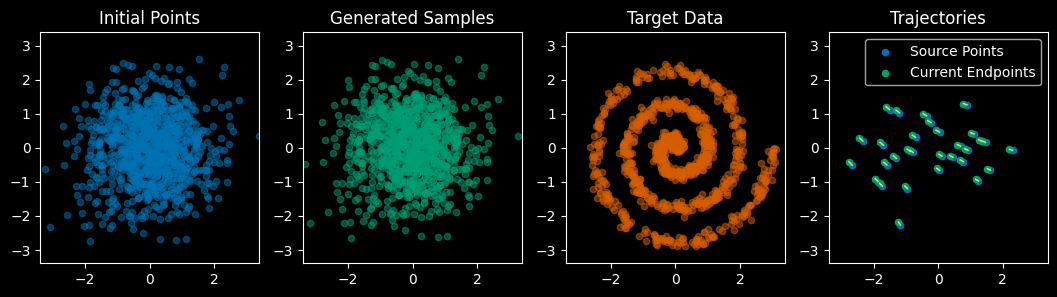

In [ ]:
#| code-fold: true
#| code-summary: "Viz code: calls integrator to calc motion given v field, makes pictures"

def viz(val_points, target_samples, trained_model, size=20, alpha=0.5, n_steps=100, warp_fn=None,):
    # Generate and visualize new samples
    device = next(trained_model.parameters()).device
    generated_samples, trajectories = integrate_path(trained_model, val_points.to(device), n_steps=n_steps, warp_fn=warp_fn, save_trajectories=True)

    n_viz = min(30, len(trajectories[0]))  # Number of trajectories to visualize
    
    fig, ax = plt.subplots(1,4, figsize=(13,3))
    data_list = [val_points.cpu(), generated_samples.cpu(), target_samples.cpu()] 
    label_list = ['Initial Points', 'Generated Samples', 'Target Data','Trajectories']
    color_list = [source_color, pred_color, target_color]
    global_max = max( torch.max(torch.abs(torch.cat(data_list)),0)[0][0],  torch.max(torch.abs(torch.cat(data_list)),0)[0][1] )
    for i in range(len(label_list)):
        ax[i].set_title(label_list[i]) 
        ax[i].set_xlim([-global_max, global_max]) 
        ax[i].set_ylim([-global_max, global_max])
        if i < 3: # non-trajectory plots
            ax[i].scatter( data_list[i][:, 0], data_list[i][:, 1], s=size, alpha=alpha, 
                          label=label_list[i], color=color_list[i])
        else:
            # Plot trajectory paths first
            for j in range(n_viz):
                path = trajectories[:, j]
                ax[3].plot(path[:, 0], path[:, 1], '-', color=line_color, alpha=1, linewidth=1)
            
            # Then plot start and end points for the SAME trajectories
            start_points = trajectories[0, :n_viz]
            end_points = trajectories[-1, :n_viz]  
            ax[3].scatter(start_points[:, 0], start_points[:, 1], color=source_color, s=size, alpha=1, label='Source Points')
            ax[3].scatter(end_points[:, 0], end_points[:, 1], color=pred_color, s=size, alpha=1, label='Current Endpoints')
            ax[3].legend()

    plt.show()
    plt.close()

# Visualize the data
n_samples = 1000
source_samples = create_source_data(n_samples)
target_samples = create_target_data(n_samples)
val_points = create_source_data(n_samples)
print("Testing visualization routines (before training):") 
viz(val_points, target_samples,  model) 

The clever part about flow matching is how we train this network. For each training step:

1. Sample random points from our source distribution
2. Sample random time points between 0 and 1
3. Calculate where these points *should* be at those times (we'll see how in a moment)
4. Calculate what velocity they *should* have at those times
5. Train the network to predict these velocities

In [ ]:
#| code-fold: true
#| code-summary: "Code for train_model() training loop"
import torch.optim as optim

def train_model(model, n_epochs=100, lr=0.003, batch_size=2048, status_every=1, viz_every=1, warp_fn=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    device = next(model.parameters()).device
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()
    
            # by randomly generating new data each step, we prevent the model from merely memorizing
            source_samples = create_source_data(batch_size).to(device)
            target_samples = create_target_data(batch_size).to(device)
            
            t = torch.rand(source_samples.size(0), 1).to(device)  # random times for traning
            if warp_fn: t = warp_fn(t)    # time warp is good for coverage but not as helpful for training as it is during integration/sampling
            interpolated_samples = source_samples * (1 - t) + target_samples * t
            line_directions = target_samples - source_samples
            
            drift = model(interpolated_samples, t)
            loss = loss_fn(drift, line_directions)
            
            loss.backward()
            optimizer.step()

            status_str = f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}'
            pbar.set_description(status_str)
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
            
        if epoch==n_epochs-1: print(status_str)  # keep last status from being cleared
    
    return model




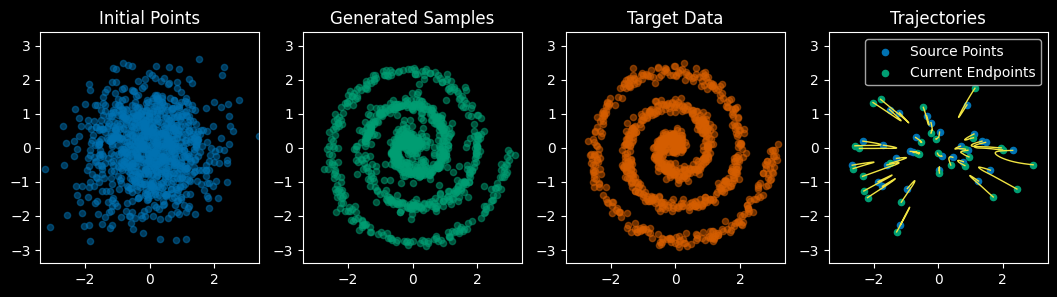

Epoch [100/100], Loss: 1.8103


In [ ]:
fm_model = train_model(model, n_epochs=100)     # this will take a couple minutes

Here's an animation of our model integrating the flow from start to finish:

In [ ]:
#| code-fold: true
#| code-summary: "Code for animating points in flow"
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
from matplotlib import rc
import os

@torch.no_grad()
def create_flow_animation(start_dist, models, titles=None, figsize=None, n_frames=50,
                         step_fn=fwd_euler_step, n_steps=100, warp_fn=None, save_file=None, height=4):
    """
    Create an animation showing multiple distribution flows
    
    Args:
        start_dist: Starting distribution
        models: List of models to animate
        titles: List of titles for each subplot (optional)
        figsize: Figure size (optional)
        n_frames: Number of animation frames
        integrator: Integration function to use
        jitter: Amount of jitter to add
        save_file: Path to save animation (optional)
        height: Height of each subplot
    """
    plt.close('all')  # Close all open figures
    
    if not isinstance(models, list): models = [models]
    n_plots = len(models)
    
    if titles is None:
        titles = [f'Flow {i+1}' for i in range(n_plots)]
    elif len(titles) != n_plots:
        raise ValueError(f"Number of titles ({len(titles)}) must match number of models ({n_plots})")
    
    # Calculate figure size
    if figsize is None:
        figsize = [height * n_plots, height]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    plt.close()  # Close the figure immediately

    
    # Initialize scatters and trajectories
    scatters = []
    all_trajectories = []
    
    # Generate trajectories for each model
    max_range = abs(start_dist).max().item()
    
    for i, model in enumerate(models):
        device = next(model.parameters()).device
        end_dist, trajectories = integrate_path(model, start_dist.clone().to(device), n_steps=n_frames,  
                                          step_fn=step_fn, warp_fn=warp_fn, save_trajectories=True)
        all_trajectories.append(trajectories.cpu())
        scatters.append(axes[i].scatter([], [], alpha=0.6, s=10, color=wong_pink))
        
        # Update max range
        max_range = max(max_range, abs(end_dist.cpu()).max().item())
    
    # Set up axes
    for i, ax in enumerate(axes):
        ax.set_xlim((-max_range, max_range))
        ax.set_ylim((-max_range, max_range))
        ax.set_aspect('equal')
        ax.set_xticks([])
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
        ax.set_title(titles[i])
    
    def init():
        """Initialize animation"""
        for scatter in scatters:
            scatter.set_offsets(np.c_[[], []])
        return tuple(scatters)
    
    def animate(frame):
        """Update animation frame"""
        # Update axis limits (in case they need to be adjusted)
        for ax in axes:
            ax.set_xlim((-max_range, max_range))
            ax.set_ylim((-max_range, max_range))
        
        # Update scatter positions
        for scatter, trajectories in zip(scatters, all_trajectories):
            scatter.set_offsets(trajectories[frame].numpy())
        
        return tuple(scatters)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=True)
    
    # Handle saving or displaying
    if save_file:
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        anim.save(save_file, writer='ffmpeg', fps=30)
        return HTML(f"""<center><video height="350" controls loop><source src="{anim_file}" type="video/mp4">
              Your browser does not support the video tag. </video></center>""")
    else:  # direct matplotlib anim offers better controls but makes ipynb file size huge
        rc('animation', html='jshtml')
        return HTML(anim.to_jshtml())
    plt.close()



anim_file = 'images/particles_fm.mp4'
create_flow_animation(val_points.clone(), models=[fm_model], titles=['Flow Matching'],
                      n_frames=50, save_file=anim_file)

So, even though we trained using trajectories that crossed, what the model learned were non-crossing (but curvy!) trajectories. Here's a static plot of these:

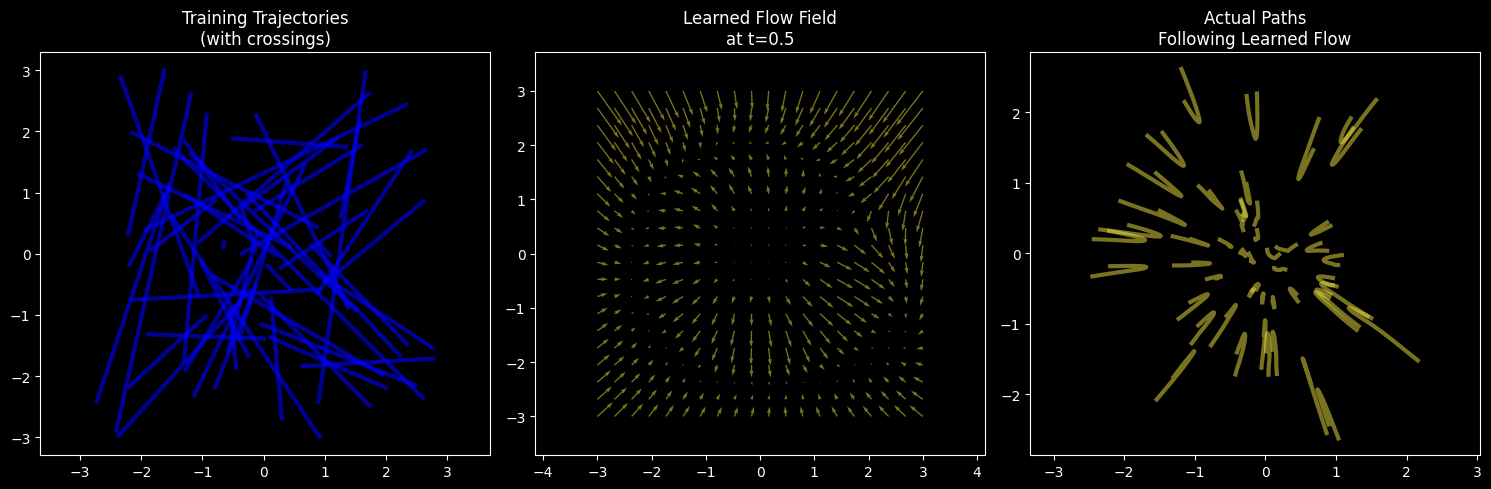

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"
@torch.no_grad()
def plot_training_trajectories_vs_learned_flow(model):
   """Compare training trajectories with learned flow field"""
   plt.figure(figsize=(15, 5))
   
   # 1. Plot some training trajectories
   plt.subplot(131)
   n_trajs = 50  # Number of trajectories to show
   device = next(model.parameters()).device
   source = create_gaussian_data(n_trajs)
   target = create_square_data(n_trajs)
   current_points = source.clone().to(device)

   
   # Plot straight-line trajectories from source to target
   times = torch.linspace(0, 1, 20)
   for i in range(n_trajs):
       traj = source[i:i+1] * (1 - times.reshape(-1, 1)) + target[i:i+1] * times.reshape(-1, 1)
       plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.6, linewidth=3)
   plt.title('Training Trajectories\n(with crossings)')
   plt.axis('equal')
   
   # 2. Plot learned flow field
   plt.subplot(132)
   x = torch.linspace(-3, 3, 20)
   y = torch.linspace(-3, 3, 20)
   X, Y = torch.meshgrid(x, y, indexing='ij')
   points = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
   
   # with torch.no_grad():
   #     t =  0.5  # Show flow field at t=0.5
   #     ones = torch.ones(points.size(0), 1)

   ones = torch.ones(points.size(0), 1).to(device)
   t = ones * (0.5)
   velocities = model(points, t).cpu()
   #print("points.shape, ones.shape = ",points.shape, ones.shape) 
   #velocities = model(points, t*ones)
   points = points.cpu()
   plt.quiver(points[:, 0], points[:, 1], 
             velocities[:, 0], velocities[:, 1],
             alpha=0.5, color=line_color, linewidth=3)
   plt.title('Learned Flow Field\nat t=0.5')
   plt.axis('equal')
   
   # 3. Plot actual paths taken using learned flow
   plt.subplot(133)
   source = create_gaussian_data(n_trajs)
   
   # Use RK4 to follow the learned flow
   paths = []
   n_steps = 20
   dt = 1.0 / n_steps
   
   with torch.no_grad():
       ones = torch.ones(current_points.size(0), 1).to(device)
       for i in range(n_steps):
           paths.append(current_points.clone())
           
           # RK4 step
           t = ones * (i * dt)
           k1 = model(current_points, t)
           k2 = model(current_points + k1 * dt/2, t + dt/2)
           k3 = model(current_points + k2 * dt/2, t + dt/2)
           k4 = model(current_points + k3 * dt, t + dt)
           
           current_points = current_points + (k1 + 2*k2 + 2*k3 + k4) * dt/6
   
   paths = torch.stack(paths).cpu()
   
   # Plot the actual paths
   for i in range(n_trajs):
       traj = paths[:, i, :]
       plt.plot(traj[:, 0], traj[:, 1], color=line_color, alpha=0.5, linewidth=3)
   plt.title('Actual Paths\nFollowing Learned Flow')
   plt.axis('equal')
   
   plt.tight_layout()
   plt.savefig('images/cross_uncross_plot.png')
   plt.show()
   plt.close()

# Run the visualization
plot_training_trajectories_vs_learned_flow(fm_model)

...So we see that even though the model was trained using lots of crossing paths, it learned a smooth flow from them! 

Even though the trajectories on the right are smooth and non-crossing, their curviness means that we need to integrate slowly and carefully to avoid accruing significant error.  Good news: the "Rectified Flow" paper of Liu et al [@rectified_flow] offers a powerful way to speed up the integration by "straightening" the curved trajectories, a method they call "Reflow." 

# "Reflow" to Go Straighter & Faster
 
The Reflow idea is that, instead of randomly pairing source and target points when choose straight trajectories, we use "simulated target points" by integrating the source points forward using the learned flow model. Then we use those endpoints as the targets and assume linear motion as before.


![](images/reflow_diagram.png)

This has the effect of straightening out the curved trajectory of the flow matching model, making the new "reflowed" trajectories much easier and faster to integrate!

Essentially, Reflow is a "teacher-student" paradigm in which the (pre-)trained flow-matching model is the teacher, and new Reflowed model is the student. One can also think of this as a kind of distillation, akin to "consistency models" [@consistency_models].


Before we can rely on those integrated endpoints, we should make a couple improvements to how we use the model we just trained. 

## Upgrading Our Gear First
Neither of these upgrades require to retraining the model. They just help to make more efficient, accurate use of it so it can serve as an effective "teacher" to the "student" Reflow model we'll train below.

### More Points Where Needed (via Time Warping)

You'll notice that trajectories are sharply curved in the middle, but are straight near the start and end. Just as you'd slow down when driving around a sharp turn, we should take smaller integration steps in these curved regions for accuracy.

This idea of non-uniform temporal sampling appears throughout generative models. Esser et al.'s "FLUX" paper [@flux_paper] specifically designs their sampling distribution to concentrate points in the middle of the integration where accuracy is most crucial. The same principle applies here: during training, we need good coverage where the model needs to make careful predictions, and during inference, high-curvature regions require denser sampling.

One handy S-shaped time-warping function is this polynomial that lets us vary the concentration of points[^2]:

$$ f(t) =  4(1-s)t^3 + 6(s-1) t^2 + (3-2s)t, \ \ \ \ \ \  t\in[0,1], \ \ \ s\in[0,3/2] $$

[^2]: Note: my $f(t)$ is a close approximation to the "mode function" Eq. 20 in [@flux_paper], with their $s$ being about (1.75 - $s_{\rm mine}$), and with $t\rightarrow 1-t$.  My blue line is right underneath their purple line in the Desmos graph below -- I didn't plan that, just similar minds at work!  Both our curves can do the Karras et al cosine schedule, shown in green in the the Desmos figure.

In [ ]:
#| echo: false
# Jupyter's markdown won't perform the iframe embed unless we "execute" the HTML code??
HTML("""
<center>
<a href="https://www.desmos.com/calculator/g6ffbljlng">
<iframe src="https://www.desmos.com/calculator/hfjxlwycmz?embed" width="225" height="225" style="border: 1px solid #ccc" frameborder=0></iframe>
<br>Interactive Desmos Graph Link</a>
<br><br>
""")

The parameter $s$ is the slope at t=1/2, and controls where points concentrate: values between 0 and 1 give us more points in the middle, which is exactly what we want for these curved trajectories. The value $s=0.5$ is a good choice, as we'll see shortly.




This approach can improve accuracy and/or require fewer total integration steps. Let's look at the results of different amounts of time-warping around a simple parabola:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code: warp_time function"
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle. 
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s<0 or s>1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t 
    if dt:                           # warped time-step requested; use derivative
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s) 
    return tw

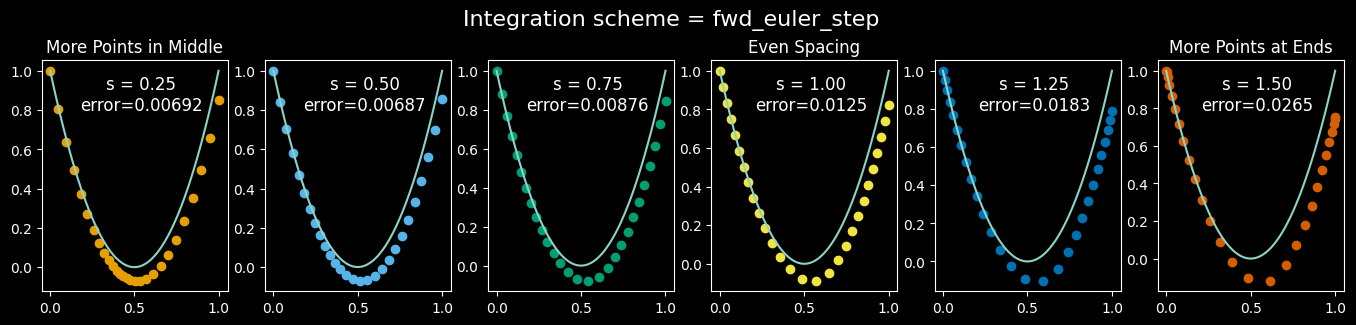

In [ ]:
#| code-fold: true
#| code-summary: "viz code for parabolic path / variable dot-spacing figure"
from functools import partial 

parab   = lambda x: 4*(x-0.5)**2  # curve shape
d_parab = lambda x: 8*(x-0.5)     # derivative
ds      = lambda x: torch.sqrt(1 + d_parab(x)**2)  # differential arc length

def calculate_total_arc_length(n=1000):
    """Calculate the total arc length of the parabola y = 4(x - 0.5)**2 from x=0 to x=1"""
    x_values = torch.linspace(0, 1, n)
    arc_length_values = ds(x_values)
    total_arc_length = torch.trapz(arc_length_values, x_values)
    return total_arc_length

def fake_velocity_model(loc, t, speed=1.0):
    """For demo purposes only: Follow a parabolic path and move at unit speed
    Compute the x and y components of the velocity along the parabola y = 4(x - 0.5)^2"""
    x, y = loc[:, 0], loc[:, 1]    
    slope = d_parab(x)
    direction = torch.stack([torch.ones_like(slope), slope], dim=1)    
    magnitude = torch.norm(direction, dim=1, keepdim=True)
    unit_velocity = direction / magnitude    
    return unit_velocity*speed

@torch.no_grad()
def integrate_motion_along_parabola(
        model, initial_points, n_steps=30, step_fn=fwd_euler_step, s=0.5,):
    """one-off integrator used only for this one visualization figure. don't use for anything else"""
    current_points = initial_points.clone()
    trajectories = [current_points.cpu().clone()]
    ts = torch.linspace(0,1.0, n_steps) 
    ts = warp_time(ts, s=s)                # here's the time worpage
    speed = calculate_total_arc_length()   # Total travel time is 1.0 so speed "=" distance
    scaled_model = partial(model, speed=speed)
    with torch.no_grad():
        for i in range(n_steps-1):
            current_points = step_fn( scaled_model , current_points.clone(), ts[i],  ts[i+1]-ts[i])
            trajectories.append(current_points.cpu().clone())
    return torch.stack(trajectories)

@torch.no_grad()
def viz_parabola_with_steps(step_fn=fwd_euler_step, n_steps=28):
    """varies warp parameter s and integrates along a parabola"""
    plt.close()
    t_curve = torch.linspace(0,1,100)

    n_t_points = n_steps # 28 if step_fn==fwd_euler_step else 6
    t_points = torch.linspace(0,1,n_t_points)

    n_s = 6    # number of different s values to show
    fig, ax = plt.subplots(1, n_s, figsize=(n_s*2.8, 3))
    plt.suptitle(f"Integration scheme = {step_fn.__name__}", fontsize=16, y=1.05)
    initial_points = torch.tensor([[0,1]])                   # one point in the top left
    for i, s in enumerate(torch.linspace(.25, 1.5, n_s)):   # warp time by different amounts via s parameter
        ax[i].plot(t_curve, parab(t_curve))    # solid line showing path
        traj = integrate_motion_along_parabola(fake_velocity_model, initial_points, n_steps=n_t_points, 
                    s=s, step_fn=step_fn).squeeze() 
        err_str = f"\nerror={F.mse_loss(parab(traj[:,0]),traj[:,1]):.3g}"
        ax[i].scatter(traj[:,0], traj[:,1], label=f's = {s:.2f}{err_str}', color=(wong_cmap*2)[i])

        legend = ax[i].legend(loc='upper center', frameon=False, markerscale=0, handlelength=0, fontsize=12)
        for text in legend.get_texts():
            text.set_ha('center')

        if abs(s-1.0) < 1e-3: ax[i].set_title('Even Spacing') 
            
    ax[0].set_title('More Points in Middle')
    ax[-1].set_title('More Points at Ends')
    plt.show()
    plt.close()

viz_parabola_with_steps() 

While the results for $s=0.5$ are better than the others, we see that *none* of these examples make it all the way around the parabola (to the point (1,1))! If we're going to be using the flow matching model as a proxy for the true target data, we should have some confidence that it's actually "getting to" the target data.  We could add more points to the integration, but there's another way: upgrade the integration (i.e. sampling) operation to a higher order of accuracy.

###  Better Integration / Sampling 

While forward Euler is surprisingly popular in ML circles, those with simulation backgrounds eye it with suspicion: despite being being fast and easy to implement,  it's also highly inaccurate and can lead to instabilities. The poor accuracy may not be an issue when everything's an approximation anyway, but we can do a lot better. 

People who work with diffusion models know this, e.g. in [Katherine Crowson's k-diffusion package](https://github.com/crowsonkb/k-diffusion) offers a bevy of integration choices.  For here we'll just implement the popular 4th-order Runge-Kutta (RK4) scheme. It's more "expensive" than forward Euler in that each step requires 4 function evaluations instead of forward Euler's 1 step, and it requires some extra storage, but the advantages you gain in accuracy are seriously worth it (e.g., because you can take much longer steps in time). 

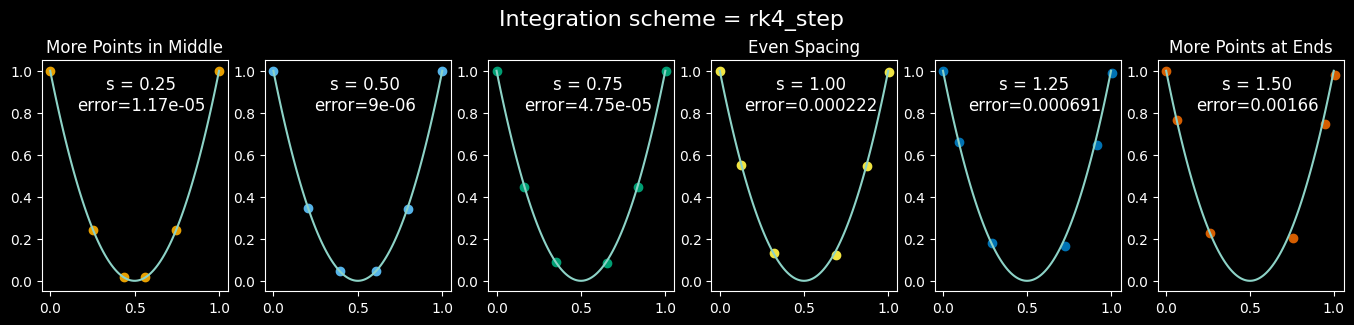

In [ ]:
#| code-fold: true
#| code-summary: "Code for 4th-order Runge-Kutta integration"
def rk4_step(f, # function that takes (t,y) and returns dy/dt, i.e. velocity
             y, # current location
             t, # current t value
             dt, # requested time step size 
             ):
    k1 =  f(y, t)
    k2 =  f(y + dt*k1/2, t + dt/2) 
    k3 =  f(y + dt*k2/2, t + dt/2) 
    k4 =  f(y + dt*k3, t + dt) 
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

viz_parabola_with_steps(step_fn=rk4_step, n_steps=6) 

It's cool how the RK4 results, despite showing less error that the Euler results, actually involve *less* computational cost in terms of number of function evaluations, though the RK4 scheme needs 4 times the storage compared for forward Euler. (The good news is that no PyTorch gradients need to be stored; the integrator is only ever used when the model is in "eval" mode.)

## Learning to "ReFlow"

When we train the "Reflowed" model, aka the student model, note that the "target data" will no longer be supplied by the true target data anymore.  Rather, we will be using the trajectory endpoints integrated/generated using the teacher model, i.e. the pretrained flow matching model.  

So we might ask... how close of an approximation are those learned flow endpoints to the real thing?   We're going to be approximating an approximation, but how good is the original approximation? 

Let's take a look...

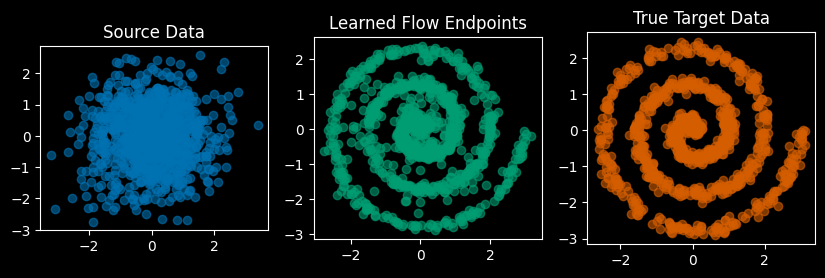

In [ ]:
#| code-fold: true
#| code-summary: "quick check of how our flow endpoints are looking"
pretrained_model = fm_model 
pretrained_model.eval()
reflow_targets = integrate_path(pretrained_model, val_points.to(device), n_steps=8, step_fn=rk4_step, warp_fn=warp_time).cpu()

fig, ax = plt.subplots(1,3, figsize=(10,3))
for i, [data, color, label] in enumerate(zip([val_points,   reflow_targets, target_samples], 
                                             [source_color, pred_color,     target_color],
                                             ['Source Data', 'Learned Flow Endpoints', 'True Target Data'])):
    ax[i].scatter(data[:,0], data[:,1], color=color, label=label, alpha=0.6)
    ax[i].set_aspect('equal')
    ax[i].set_title(label)
plt.show()
plt.close()

....ok, so we see the learned outputs are a bit different from the true data, but they're not bad.  Let's now train the "reflow" model. 

### Train the Reflowed Model

There's one small but crucial change from the previous training code to this one, namely what we use as target data: 
```python
##  target_samples = create_target_data(batch_size)           # Previous "random pairing"
target_samples = integrator(pretrained_model, source_samples) # Reflow!
```

In [ ]:
#| code-fold: true
#| code-summary: "Code for the new training loop w/ ReFlowed targets"
def train_reflow_model(model, pretrained_model=None, 
                          n_epochs=40, lr=0.001, batch_size=2048, 
                          status_every=1, viz_every=1, # in epochs
                          new_points_every=1, # in steps 
                          warp_fn=warp_time, 
                          step_fn=rk4_step, # rk4 so we get high-quality outputs while reflowing
                          ):
    """This is almost IDENTICAL to the previous training routine. 
        The difference is the change in "target_samples" via what the RF authors call "ReFlow": 
        Instead of (randomly) paring source points with points in the "true target distribution", 
        we use the pretrained/teacher model to integrate the source points to their (predicted) flow endpoints 
        and use THOSE as the "target" values.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    device = next(model.parameters()).device
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()

            if step % new_points_every == 0:  # you could in theory not draw new points with each step, though we will. 
                source_samples = create_source_data(batch_size).to(device)
                if pretrained_model:   # HERE is the ReFlow operation...
                    target_samples = integrate_path(pretrained_model, source_samples, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)  
                else:
                    target_samples = create_target_data(batch_size) # this function also supports fm models from scratch
                    
            t = torch.rand(source_samples.size(0), 1).to(device) # random times for training
            if warp_fn: t = warp_fn(t)  # time warp here (different from use in integrator!) helps focus "coverage" i.e. sampling the space
                
            interpolated_samples = source_samples * (1 - t) + target_samples * t            
            v = model(interpolated_samples, t)
            line_directions = target_samples - source_samples 
            loss = loss_fn(v, line_directions)
            
            loss.backward()
            optimizer.step()
            
            pbar.set_description(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4g}')
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)  # don't need rk4 for rect model viz b/c paths r straight
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
    
    return model

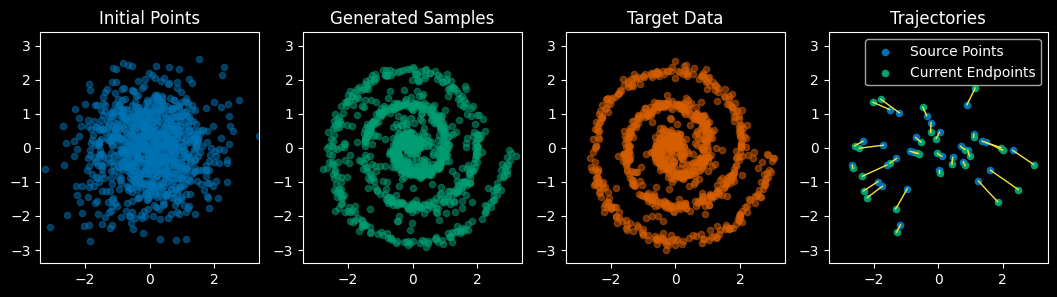

In [ ]:
import copy

reflowed_model = copy.deepcopy(pretrained_model) # no need to train student from scratch, start from teacher's weights
reflowed_model.train()

reflowed_model = train_reflow_model(reflowed_model, pretrained_model=pretrained_model)

Oooo, look how straight the trajectories are now!  Let's compare animations of the original flow matching model with the "Reflowed" model: 

In [ ]:
#| code-fold: true
#| code-summary: "Making movie for particle animation comparison"
rect_eval = reflowed_model.eval()

anim_file = "images/particles_fm_vs_rf.mp4"
create_flow_animation(val_points.clone(), models=[pretrained_model, reflowed_model], 
        n_frames=50, titles=['Flow Matching','Reflowed Flow'], save_file=anim_file)

Notice how the flow matching trajectories on the left have the data moving inward a ways and then back out, whereas the reflowed trajectories move directly from start to finish with no backtracking.

The next movie shows an animation of "streamlines" with arrows for the local vector field. Note how the shapes on the right change very little over time compared to those on the left. We'll say a bit more about that below. 

In [ ]:
#| code-fold: true
#| code-summary: "Code for streamline animation"
@torch.no_grad()
def create_streamline_animation(start_dist, model, model2=None, n_frames=50, show_points=False, titles=None, 
                                step_fn=fwd_euler_step,  # euler's ok for reflowed model bc/paths are straight
                                save_file=None, 
                               ):
    """Create an animation showing distribution flow with streamplot background"""
    device = next(model.parameters()).device
    figsize = [5,5]
    if titles is None: 
        titles = ['Flow Matching']
        if model2: titles += ['Rectified Flow']
    if model2: 
        figsize[0] *= 2
    n_plots = 1 + (model2 is not None)
    fig, ax = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots==1: ax = [ax]
    plt.close()

    end_dist, trajectories = integrate_path(model, start_dist.clone().to(device), n_steps=n_frames, step_fn=step_fn, warp_fn=warp_time, save_trajectories=True)
    scatter = ax[0].scatter([], [], alpha=0.6, s=10, color=wong_pink, zorder=1)
    if model2: 
        _, trajectories2 = integrate_path(model2, start_dist.clone().to(device), n_steps=n_frames, step_fn=step_fn, warp_fn=warp_time, save_trajectories=True)
        scatter2 = ax[1].scatter([], [], alpha=0.6, s=10, color=wong_pink, zorder=1)
        
    max_range = max( abs(start_dist).max().item(), abs(end_dist).max().item() )
    
    for i in range(len(ax)):
        ax[i].set_xlim((-max_range, max_range))
        ax[i].set_ylim((-max_range, max_range))
        ax[i].set_aspect('equal')
        if titles: ax[i].set_title(titles[i])


    # Create grid for streamplot
    grid_dim = 50
    x = np.linspace(-max_range, max_range, grid_dim)
    y = np.linspace(-max_range, max_range, grid_dim)
    X, Y = np.meshgrid(x, y)

    # Convert grid to torch tensor for model input
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32).to(device)
    color = wong_pink if show_points else (0,0,0,0) 

    dt = 1.0 / n_frames 
    
    def init():
        for i in range(len(ax)):
            ax[i].clear()
            ax[i].set_xlim((-max_range, max_range))
            ax[i].set_ylim((-max_range, max_range))
        scatter.set_offsets(np.c_[[], []])
        if model2:
                scatter.set_offsets(np.c_[[], []])
                return (scatter,scatter2)
        return (scatter,)
    
    def animate(frame):
        for i in range(len(ax)):
            ax[i].clear()
            ax[i].set_xlim((-max_range, max_range))
            ax[i].set_ylim((-max_range, max_range))
            if titles: ax[i].set_title(titles[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            for spine in ['top','right','bottom','left']:
                ax[i].spines[spine].set_visible(False)

        # Update scatter plot
        current = trajectories[frame]
        scatter = ax[0].scatter(current[:, 0], current[:, 1], alpha=0.6, s=10, color=color, zorder=1)
        if model2:
            current2 = trajectories2[frame]
            scatter2 = ax[i].scatter(current2[:, 0], current2[:, 1], alpha=0.6, s=10, color=color, zorder=1)

        # Calculate vector field for current time
        t = torch.ones(grid_points.size(0), 1) * (frame * dt)
        t = warp_time(t).to(device) 
        velocities = model(grid_points, t).cpu()
        U = velocities[:, 0].reshape(X.shape)
        V = velocities[:, 1].reshape(X.shape)

        x_points = np.linspace(-max_range, max_range, 15)
        y_points = np.linspace(-max_range, max_range, 15)
        X_arrows, Y_arrows = np.meshgrid(x_points, y_points)
        start_points = np.column_stack((X_arrows.ravel(), Y_arrows.ravel()))
        ax[0].streamplot(X, Y, U.numpy(), V.numpy(),
             density=5,  # Controls line spacing
             color=line_color, # (0, 0, 1, 0.7),
             linewidth=0.8, maxlength=0.12,
             start_points=start_points,  # This should give more arrows along paths
             arrowsize=1.2,
             arrowstyle='->')  
        
        if model2: 
            velocities2 = model2(grid_points, t).cpu()
            U2 = velocities2[:, 0].reshape(X.shape)
            V2 = velocities2[:, 1].reshape(X.shape)
            start_points2 = np.column_stack((X_arrows.ravel(), Y_arrows.ravel()))
            ax[1].streamplot(X, Y, U2.numpy(), V2.numpy(),
                 density=5,  # Controls line spacing
                 color=line_color, # (0, 0, 1, 0.7),
                 linewidth=0.8, maxlength=0.12,
                 start_points=start_points2,  # This should give more arrows along paths
                 arrowsize=1.2,
                 arrowstyle='->') 


        # Update particle positions
        t = torch.ones(current.size(0), 1) * (frame * dt)
        t, dtw = warp_time(t, dt=dt)
        velocity = model(current.to(device), t.to(device)).cpu()
        current = current + velocity * dtw
        if model2: 
            velocity2 = model2(current2.to(device), t.to(device)).cpu()
            current2 = current2 + velocity2 * dtw
            return (scatter, scatter2,)
        return (scatter,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=False)

    if save_file:
        anim.save(save_file, writer='ffmpeg', fps=30)
        return HTML(f"""<center><video height="350" controls loop><source src="{save_file}" type="video/mp4">
                      Your browser does not support the video tag.</video></center>""")
    else:
        rc('animation', html='jshtml')
        return HTML(anim.to_jshtml())


save_file = 'images/fm_vs_rf_streamvecs.mp4'
create_streamline_animation(val_points, fm_model, model2=reflowed_model, n_frames=50, save_file=save_file)#, show_points=True)

# Connecting with Other Models


### From Dots to Images, Audio, etc..

How to move on from 2D dots to things like images, text, audio,...etc? We need only consider that the dimensionality of the velocity model is the same as that of the data itself.  Put differently, one can regard the velocity model as supply a tiny "change" to the data, whatever form that data is in. And the "straight line" trajectory used during training? That's just linear interpolation between the (initially randomly-paired) source data and the target data.  So for images, we will get a "velocity image", which will tell us how to change the R,G,B value of every pixel in an image.  This is where U-Nets and Attention come in to play, to compute the "image-to-image" task of supplying a "velocity image" given an input image distribution (which may just be noise).   For audio, regardless of the representation, the velocity model will tell us how to slightly change the component values in that representation. We then just integrate all the little changes as we did with the dots.

*  I recommend checking out an MNIST image example such as Tadao Yamaoka's [@rf_mnist_example]


### Diffusion Models

Diffusion-models, aka "score-based models" are similar to flow models in that the former also learn a vector field (the "score function") that serves to differentially transform the points in the sample.  The difference is that flow models are deterministic, whereas diffusion models are constantly injecting fresh noise, as if they are simulating actual brownian motion rather than the macroscopic flow.  To turn our flow model into a diffusion model, we could add "jitter," i.e. inject noise at every step.  The variance of that jitter as a function of time would correspond directly to the "noise schedule" of diffusion models.  
<!-- There's a lot more than can be said (and has been said) about the many connections between diffusion models and flow-based models, but for brevity's sake we'll move on for now. --> 


### Optimal Transport 

Interesting observation: See how the Reflowed streamlines in the last movie are approximately stationary (i.e., time-independent)? This connects nicely with Optimal Transport theory, where the Benamou-Brenier formulation [@bb_form] (which has a diffusion-esque equation as on objective) shows that optimal mass transport paths follow constant-velocity geodesics in the Wasserstein metric space. This time-independence property emerges naturally when minimizing transport costs in simple metric spaces, as particles following straight-line paths at constant speeds achieve optimal transport between distributions.



### Normalizing Flows 

Normalizing flows have the property that they preserve overall probability throughout the flow process. While this would seem to be a nice constraint to satisfy, it appears to be unnecessary for "getting the job done" yet it can limit the expressiveness of the model compared to kinds of flows we've been talking about in this post. Note: Since I'm pushing a "physics perspective," a similar "conservation" property arises in the phase space flows of Hamiltonian mechanics, namely that they preserve areas and volumes via Liousville's Theorem [@liouvilles_theorem]. The connection between normalizing flows and Hamiltonian systems was applied to generative modeling in the "Neural Hamiltonian Flows" paper of ICLR 2020 [@Toth2020Hamiltonian], and continues in a recent NeurIPS 2024 poster-paper [@hamiltonian_flows].[^3] Despite these fascinating connections, the exciting thing about flow-matching and rectified flows is that they seem to be effective even in the absence of the explicit conservation properties of normalizing flows and their relatives, and can thus be implemented quickly and simply. 

[^3]: Check out [Yilun Xu's](https://yilun-xu.com/) work for more on physics-inspired generative models.




# Summary

We've seen that flow matching and rectified flows models can be conceptualized and even developed using some simple ideas from basic physics. This simplicy, coupled with their power and flexibility have fueled their popularity and even rise to state-of-the-art levels.  

Hopefully, after having read this, you will be able to better follow the rapid progress in flow-based generative AI in terms of both scholarly and industry output, as well as to have the confidence to expand on these ideas for your own investigations!

# References

::: {#refs}
:::

---
(c) 2024 Scott H. Hawley 

#### Acknowledgement  {.unnumbered}
This work was graciously supported by Belmont University, Hyperstate Music AI, Razer Inc., and NVIDIA's Inception program. Much of this tutorial was hashed out through "conversations" with Claude 3.5 Sonnet.  